In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import sqlite3

# Symbol
symbol = 'BTCUSDT'

# Start and end time stamps
start_year = 2023
start_month = 1
start_day = 1

start_datetime = datetime.datetime(start_year, start_month, start_day)
start_timestamp = time.mktime(start_datetime.timetuple()) * 1000 # In milliseconds 
start_timestamp = int(start_timestamp)

end_year = 2024
end_month = 1
end_day = 1

end_datetime = datetime.datetime(end_year, end_month, end_day)
end_timestamp = time.mktime(end_datetime.timetuple()) * 1000 # In milliseconds 
end_timestamp = int(end_timestamp)

# Get data set. First I'll pull all the data at once, then refactor for a data source object
sql_check_spec = '''SELECT ticker_time, open_price, volume FROM spot_entry WHERE symbol = ? and ticker_time > ? and ticker_time < ?'''

connection = sqlite3.connect("../database/ticker_data.db")
with connection:
    cursor = connection.cursor()

sql_check_val = (symbol,) + (start_timestamp,) + (end_timestamp,)

cursor.execute(sql_check_spec, sql_check_val)
spot_data = cursor.fetchall()
spot_data = np.array(spot_data)


In [2]:
#


t = (spot_data[:,0] - spot_data[0,0]) / 1000/ 60 / 60 / 24
open_price = spot_data[:,1]
volume = spot_data[:,2]
n_points = len(t)

# n_momentum = np.array([1, 3,  10, 21, 50],  dtype=int) 
n_momentum = np.array([14],  dtype=int) 
window_samples = n_momentum * 24 * 60

n_trades = 0
t_trade = np.array(t[window_samples])


In [15]:
momentum_vals = np.array(range(1,51),  dtype=int) 
final_holdings = np.array([])

for m in momentum_vals:
	window_samples = m * 24 * 60

	n_trades = 0
	t_trade = np.array(t[window_samples])

	usd = 100
	btc = 0
	btc_hold = usd / open_price[window_samples]

	momentum_arr = np.array([[]])
	usd_balance = np.array([])
	btc_hold_arr = np.array([])
	t_step = np.array([])
	t_trade = np.array([])

	for current_index in range(window_samples, n_points, 10):
		
		current_time = t[current_index]
		t_step = np.append(t_step, current_time)

		segment_start_idx = current_index - window_samples
		current_price = open_price[current_index]
		delay_price = open_price[segment_start_idx]

		momentum = current_price - delay_price
		momentum_arr = np.vstack([momentum_arr, momentum]) if momentum_arr.size else momentum
		
		btc_hold_arr = np.append(btc_hold_arr, btc_hold * current_price)

		if btc:
			usd_balance = np.append(usd_balance, btc * current_price)
			if momentum < 0:
				usd = btc * current_price
				btc = 0
				t_trade = np.append(t_trade, current_time)
		else:
			usd_balance = np.append(usd_balance, usd)
			if momentum > 0: 
				btc = usd / current_price
				usd = 0
				t_trade = np.append(t_trade, current_time)


	if btc:
		final_holdings = np.append(final_holdings, btc * current_price) 
		print(btc * current_price)
	else:
		final_holdings = np.append(final_holdings, usd) 
		print(usd)
	



149.79063464069952
167.50573919601715
206.58226798919128
178.54056810484164
188.38411046937716
183.29499891120938
200.53129357636774
196.32173967344684
163.90219448397502
175.65455108388042
157.9167034541737
137.92495824015012
145.69691901302076
154.23817397474346
171.60079448185863
145.2596648901579
133.10989993202344
152.0333917938008
150.0597116985267
157.48235327688644
141.5174649368842
146.43214221831226
133.97011580748205
123.51590458820394
149.69683215056943
158.30422129489114
172.07843383668637
161.65655202073904
166.47258979119403
181.9715032329202
175.48647315408354
157.94508002246656
157.8168025149348
159.2693473056797
156.08832120142438
162.3660964819764
158.92429292209954
175.12732951933796
178.27424711166373
198.08541950627
176.5005830944355
172.11096820269225
183.1717558445231
162.64450057491106
152.43091892225837
137.5120762748749
138.26899438865678
142.97760369657075
137.39872366511844
140.99707515756575


0.004019365302025157


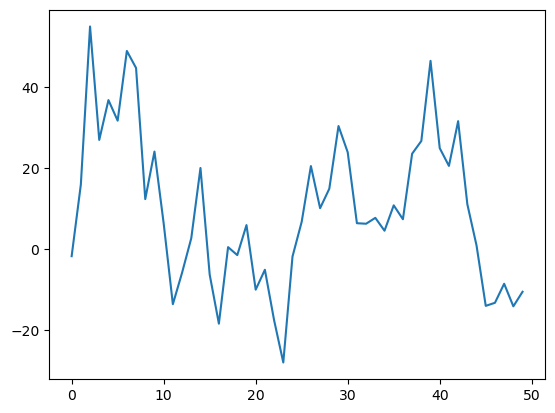

In [16]:
fig, ax = plt.subplots(1,1)
ax.plot(final_holdings - btc_hold_arr[-1])
print(btc_hold)
plt.show()

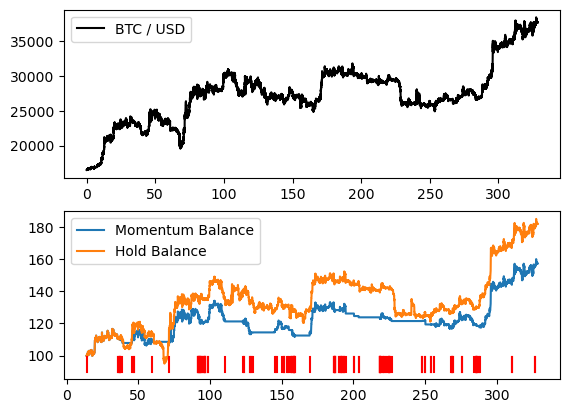

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t,open_price,color='black', label='BTC / USD')
ax1.legend()

ax2.plot(t_step, usd_balance, label='Momentum Balance')
ax2.plot(t_step, btc_hold_arr, label='Hold Balance')
ax2.legend()

trade_bars_x = np.vstack([t_trade, t_trade])
trade_bars_y = np.vstack([90 * np.ones_like(t_trade), 99 * np.ones_like(t_trade)])

ax2.plot(trade_bars_x,trade_bars_y, color='red')
plt.show()